# Run Monte Carlo Simulation in Brightway

Now we are ready to start doing more intense simulations. In particular Brightway2 is great to perform fast error propagation with Monte Carlo simulation. 

This script shows how to add uncertainties to your home-made product system and run a Monte Carlo simulation. 

To better understand this script, I recommend reading read the paper by Limpert et al. (2001), that is a 'classic' and explains the log-normal distribution.

_Limpert, E., Stahel, W. A., & Abbt, M. (2001). Log-normal distributions across the sciences: Keys and clues. Bioscience, 51(5), 341-352. [https://doi.org/10.1641/0006-3568(2001)051[0341:LNDATS]2.0.CO;2](https://academic.oup.com/bioscience/article/51/5/341/243981)_

In [3]:
import brightway2 as bw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
bw.projects.set_current('advlca23')

In [5]:
bw.databases

Databases dictionary with 5 object(s):
	biosphere3
	ecoinvent 3.9 conseq
	exldb
	testbiosphere
	testdb

A short recap from yesterday, let's create a database and run LCA calcualtions

In [6]:
t_db = bw.Database('testdb')

t_db.write({  # A simplified version, only CO2 as emission
    ('testdb', 'Electricity production'): {
        'name': 'Electricity production',
        'unit': 'kWh',
        'exchanges': [{
                'input': ('testdb', 'Fuel production'),
                'amount': -2,
                'unit': 'kg',
                'type': 'technosphere'
            }, {
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 1,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Electricity production'),
                'amount': 10,
                'unit': 'kWh',
                'type': 'production'
            }]
        },
    ('testdb', 'Fuel production'): {
        'name': 'Fuel production',
        'unit': 'kg',
        'exchanges': [{
                'input': ('testdb', 'Carbon dioxide'),
                'amount': 10,
                'unit': 'kg',
                'type': 'biosphere'
            }, {
                'input': ('testdb', 'Fuel production'),
                'amount': 100,
                'unit': 'kg',
                'type': 'production'
            }]
    },
    ('testdb', 'Carbon dioxide'): {'name': 'Carbon dioxide', 'unit': 'kg', 'type': 'biosphere'}
    })


myLCIAdata = [[('testdb', 'Carbon dioxide'), 1.0]]
method_key = ('simplemethod', 'imaginaryendpoint', 'imaginarymidpoint')
my_method = bw.Method(method_key)
my_method.validate(myLCIAdata)
my_method.register()
my_method.write(myLCIAdata)
my_method.load()

functional_unit = {t_db.get('Electricity production'): 1000}
lca = bw.LCA(functional_unit, method_key)  # LCA calculations with method
lca.lci()
lca.lcia()

print(lca.score) # Will be different from Script 1.

Writing activities to SQLite3 database:
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/23/2023 19:41:42
  Finished: 02/23/2023 19:41:42
  Total time elapsed: 00:00:00
  CPU %: 68.20
  Memory %: 1.10
80.0


What we need to rememebr is that 80 is the **static** or **deterministic** result of this LCA. We need to remember that for later.

###  Exercise / Homework
Can you obtain the same result by removing the exchanges from the database created yesterday? 
Hint: you can do this using the .Delete() method applied to an exchange.

# Now add uncertainty 

See a tutorial [here](http://nbviewer.jupyter.org/urls/bitbucket.org/cmutel/brightway2/raw/default/notebooks/Activities%20and%20exchanges.ipynb)

**Note**: uncertainties are always added to EXCHANGES (not to activities...)

So I'll get one  exchange from one activity

In [7]:
el = t_db.get('Electricity production')  
co2_exc = list(el.exchanges())[1]   # the first exchange
co2_exc

Exchange: 1 kg 'Carbon dioxide' (kg, None, None) to 'Electricity production' (kWh, None, None)>

In [8]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
co2_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
co2_exc['loc'], co2_exc['scale'] = np.log(co2_exc['amount']), np.log(1.01) 
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
co2_exc.save() # important

In [9]:
el = t_db.get('Electricity production')  
fuel_exc = list(el.exchanges())[0]   # the first exchange
fuel_exc

Exchange: -2 kg 'Fuel production' (kg, None, None) to 'Electricity production' (kWh, None, None)>

In [10]:
# Lognormal distribution first
from stats_arrays import LognormalUncertainty
import numpy as np
fuel_exc['uncertainty type'] = LognormalUncertainty.id # this is an integer (not a float)
fuel_exc['loc'], fuel_exc['scale'] = np.log(-fuel_exc['amount']), np.log(1.01)
fuel_exc['negative'] = True
'''The lognorm dist is defined here two parameters: location and scale 
i.e. by the log of the geometric mean and by the geometric standard dev'''
fuel_exc.save() # important

In [11]:
fuel_exc.uncertainty  #

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [12]:
co2_exc.uncertainty  # check that info is stored

{'uncertainty type': 2, 'loc': 0.0, 'scale': 0.009950330853168092}

In [13]:
co2_exc.as_dict()  # Now uncertainty is included

{'input': ('testdb', 'Carbon dioxide'),
 'amount': 1,
 'unit': 'kg',
 'type': 'biosphere',
 'output': ('testdb', 'Electricity production'),
 'uncertainty type': 2,
 'loc': 0.0,
 'scale': 0.009950330853168092}

In [14]:
co2_exc.random_sample(n=10)  # nice

array([1.00083205, 1.03279367, 0.98526484, 0.99187358, 1.0025918 ,
       1.00013389, 0.9764909 , 0.99999575, 0.98118651, 1.00746122])

(array([  4.,  17.,  62., 148., 212., 239., 185.,  80.,  42.,  11.]),
 array([0.96846108, 0.97462918, 0.98079729, 0.98696539, 0.9931335 ,
        0.9993016 , 1.00546971, 1.01163781, 1.01780592, 1.02397402,
        1.03014213]),
 <BarContainer object of 10 artists>)

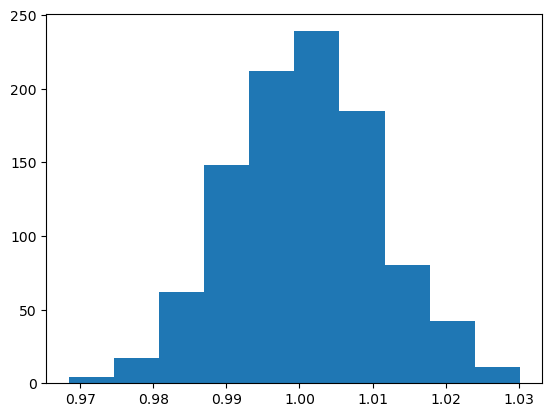

In [15]:
# if you want to see this
%matplotlib inline
plt.hist(co2_exc.random_sample(n=1000))

In [15]:
# this in case you want to try with normal dist
#from stats_arrays import NormalUncertainty

#co2_exc['uncertainty type'] = NormalUncertainty.id
#co2_exc['loc'], co2_exc['scale'] = 1, 0.01
#co2_exc.save()
#co2_exc.uncertainty  # check that
#co2_exc.as_dict()  # OK

#  Now MC simulation

(Check also this [example](http://stackoverflow.com/questions/38532146/obtaining-distribution-of-results-from-lcia))

In [16]:
# Check again that uncertainty info is stored
list(el.exchanges())[0].uncertainty

{'uncertainty type': 2,
 'loc': 0.6931471805599453,
 'scale': 0.009950330853168092,
 'negative': True}

In [17]:
# This is the montecarlo simulation
mc = bw.MonteCarloLCA({el: 1000}, method_key)  # Monte Carlo class
mc_results = [next(mc) for x in range(500)] 

# two things here:
# next() is an iterator, a peculiar python construct, check it online
# using a fuction within [ ] usig a for loop is called a "list comprehension". The result is a list

In [18]:
mc_results[1:10] # printing the first 10 elements on the list...remember, the deterministic value was 80

[80.21087564144928,
 80.597853534041,
 80.50517583246446,
 80.15782034375017,
 80.11230291340445,
 80.12602985024225,
 80.01215733125234,
 80.73580838194928,
 80.84583216442886]

Text(0.5, 0, 'lca.score')

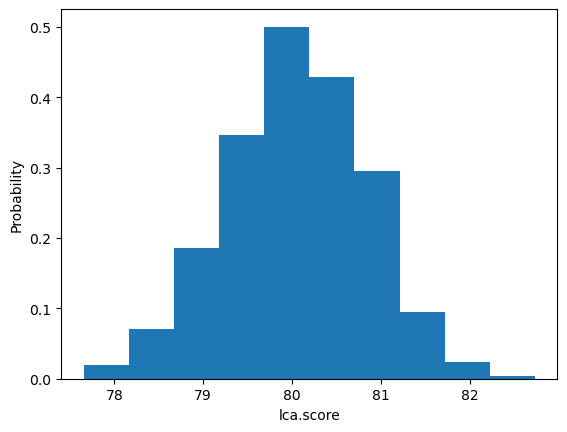

In [19]:
# Look at the MC results
plt.hist(mc_results, density=True)  # From matplotlib package. Use bins = int(500/15) to increase number of bars
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [20]:
print(np.mean(mc_results)) # from numpy package
print(np.median(mc_results)) # from numpy package
print(lca.score) # the deterministic value, we are very close to the mean and median

80.05930179971425
80.06547599368912
80.0


In [21]:
pd.DataFrame(mc_results).describe()  # from pandas package

,0
count,500.000000
mean,80.059302
std,0.787582
min,77.656990
25%,79.516914
50%,80.065476
75%,80.623939
max,82.734514


Text(0.5, 0, 'lca.score')

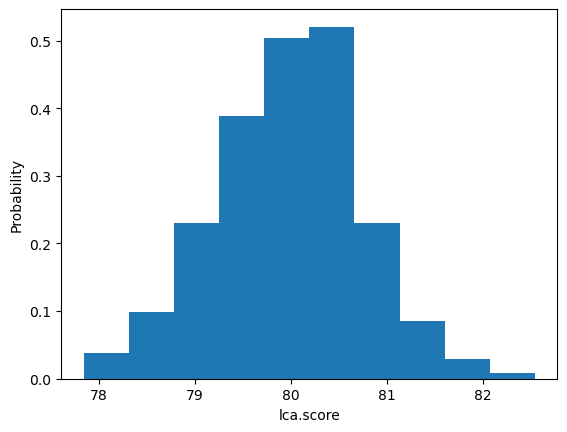

In [22]:
# Do this again and compare results
mc2 = bw.MonteCarloLCA({el: 1000}, method_key)  # Monte Carlo class
mc2_results = [next(mc2) for x in range(500)]

plt.hist(mc2_results, density=True)
plt.ylabel("Probability")
plt.xlabel('lca.score')

In [23]:
print(np.mean(mc2_results))
print(np.median(mc2_results))
print(lca.score)

79.97676537911556
80.03553400984367
80.0


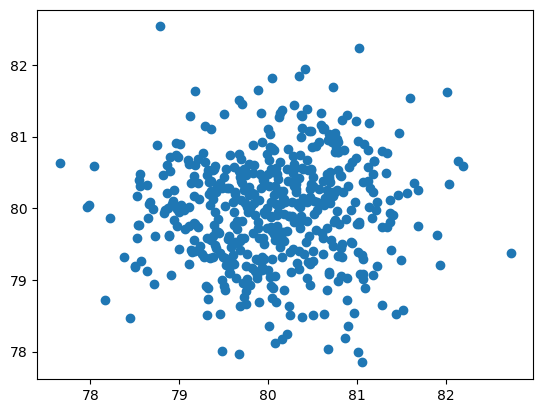

In [24]:
plt.scatter(mc_results, mc2_results) # Correct. Do you understand why?

In [25]:
# Another way to do it
iterations = 1000
scores = np.zeros([1, iterations])  # 1-dimensional array filled with zeros
for iteration in range(iterations):
    next(mc)
    scores[0, iteration] = mc.score
for i in range(1, 10):
    print(scores[0][i])  # need the zero because one-dimensional array

79.87559677055248
80.36429977374846
80.08948315460157
80.60068441337994
80.9990639178437
81.98129029758962
79.02827448738107
81.32864571390233
79.67771402590172


In [26]:
# Another way, get a list instead of an array
iterations = 1000
scores = []
for iteration in range(iterations):
    next(mc)
    scores.append(mc.score)
for i in range(1, 10):
    print(scores[i])
type(scores) == type(mc_results)  # same type of results as in the first case

79.53466651555476
80.91463085674897
80.73141584883199
81.24666832735033
79.0842511229307
81.07761940821828
79.80793992612229
80.38496020502322
79.3005739460213


True